In [1]:
from tensorflow.keras.applications.resnet import preprocess_input 
from tensorflow.keras.utils import img_to_array,load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from os import walk

### Chargement de l'ensemble de données

In [2]:
# path of the dogs images

img_files='./train_df/'


In [3]:
f = []
f1 = []
f2 = []

for (dirpath, dirnames, filenames) in walk(img_files):
    f2.extend(dirnames)
    
for dirname in f2:
    for (dirpath, dirnames, filenames) in walk(img_files+dirname):
        f.extend(list(map(lambda x: img_files+dirname+'/' + x, filenames)))
       

df_images= pd.DataFrame(zip(f), columns = ['id'])
df = df_images
df.sample(10)

,id
18273,./train_df/n02111889-Samoyed/n02111889_1762.jpg
14565,./train_df/n02107142-Doberman/n02107142_3171.jpg
18318,./train_df/n02111889-Samoyed/n02111889_3476.jpg
4271,./train_df/n02091467-Norwegian_elkhound/n02091...
4116,./train_df/n02091244-Ibizan_hound/n02091244_40...
12669,./train_df/n02105056-groenendael/n02105056_263...
821,./train_df/n02086240-Shih-Tzu/n02086240_3558.jpg
14145,./train_df/n02106382-Bouvier_des_Flandres/n021...
5167,./train_df/n02093256-Staffordshire_bullterrier...
37,./train_df/n02085620-Chihuahua/n02085620_1816.jpg


In [4]:
def get_breed(str):
    breed = str.split("-",1)[1].split("/",1)[0]
    return breed

#df['breed'] =df['img_path'].apply(lambda path: get_breed(df['img_path'].str))

df['breed']= pd.Series([get_breed(i) for i in df['id']])

# replace white spaces by underscores
df.breed = [c.replace(' ', '') for c in df.breed]

df.sample(10)

,id,breed
12576,./train_df/n02104365-schipperke/n02104365_7018...,schipperke
15009,./train_df/n02107683-Bernese_mountain_dog/n021...,Bernese_mountain_dog
1189,./train_df/n02086910-papillon/n02086910_2875.jpg,papillon
16360,./train_df/n02109525-Saint_Bernard/n02109525_1...,Saint_Bernard
10828,./train_df/n02100735-English_setter/n02100735_...,English_setter
7639,./train_df/n02096294-Australian_terrier/n02096...,Australian_terrier
3350,./train_df/n02090622-borzoi/n02090622_7111.jpg,borzoi
13212,./train_df/n02105412-kelpie/n02105412_6120.jpg,kelpie
19810,./train_df/n02113799-standard_poodle/n02113799...,standard_poodle
9065,./train_df/n02097658-silky_terrier/n02097658_2...,silky_terrier


###  Basic Visualization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20580 non-null  object
 1   breed   20580 non-null  object
dtypes: object(2)
memory usage: 321.7+ KB


In [6]:
#Number of different breed type
classes = df.breed.unique().tolist()

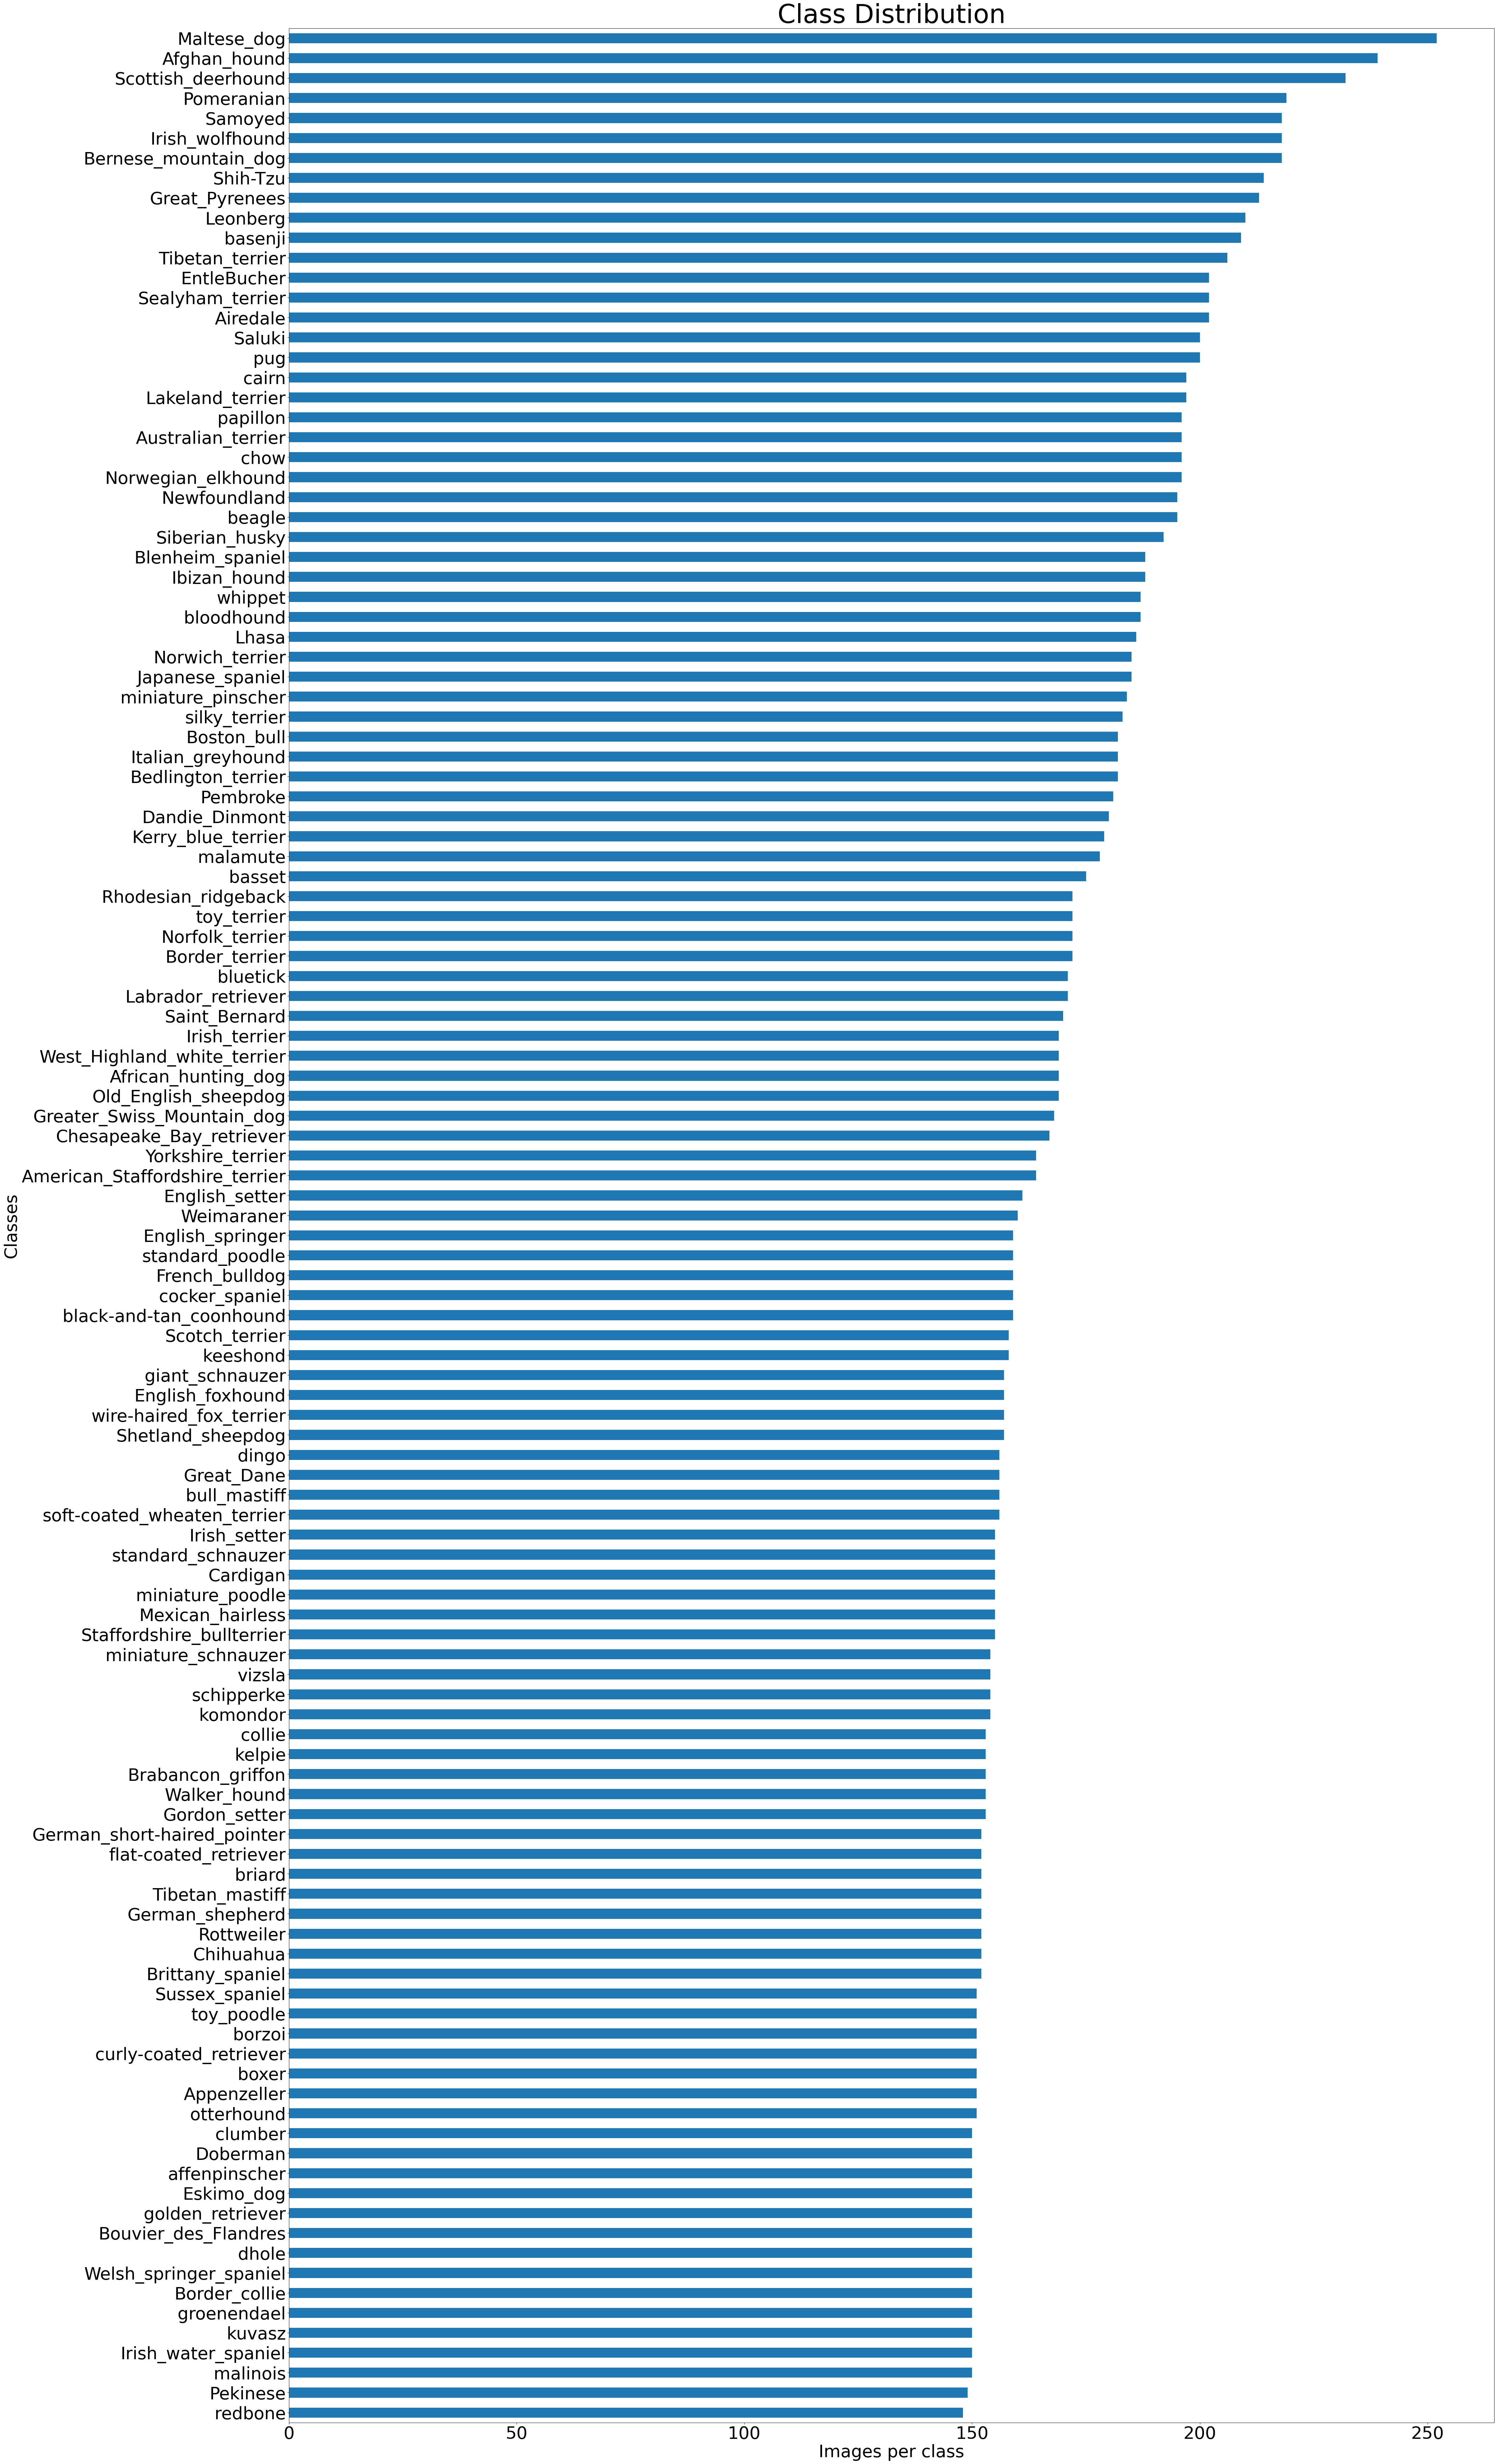

In [7]:
# Take a look at the class/breed distribution
ax=pd.value_counts(df['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [8]:
#Top 20 breed
top_20=list(df.breed.value_counts()[0:20].index)
top_20

['Maltese_dog',
 'Afghan_hound',
 'Scottish_deerhound',
 'Pomeranian',
 'Bernese_mountain_dog',
 'Samoyed',
 'Irish_wolfhound',
 'Shih-Tzu',
 'Great_Pyrenees',
 'Leonberg',
 'basenji',
 'Tibetan_terrier',
 'Sealyham_terrier',
 'EntleBucher',
 'Airedale',
 'pug',
 'Saluki',
 'cairn',
 'Lakeland_terrier',
 'Australian_terrier']

In [9]:
df2=df[df.breed.isin(top_20)].reset_index().fillna(0)
df2.shape

(4244, 3)

### Création d'un chemin pour chaque image, pour que la fonction d'assistance décode l'image.

In [10]:
labels = pd.get_dummies(df2.breed).values

### Obtenir les étiquettes dans un format d'encodage avec one-hot encoding 

In [11]:
column_names = pd.get_dummies(df2.breed).columns.to_list()

### Diviser les données en objectifs d'entraînement et de test.

In [12]:
train_path, valid_path, train_labels, valid_labels = train_test_split(df2.id, labels, test_size=0.3, random_state=42)

## Création d'un ensemble de données avec l'API tf.data pour une vitesse de calcul plus rapide

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
train_ds = tf.data.Dataset.from_tensor_slices((valid_path, valid_labels))

### Fonction d'assistance qui prendra le chemin et retournera les tenseurs de type tf.float32 de l'image.

In [14]:


train_ds=np.array([img_to_array(load_img(img, target_size=(120, 120))) for img in train_path])
valid_ds=np.array([img_to_array(load_img(img, target_size=(120, 120))) for img in valid_path])



In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

In [16]:
training_set=train_datagen.flow(train_ds,y=train_labels,batch_size=32)
testing_set=test_datagen.flow(valid_ds,y=valid_labels,batch_size=32)

In [17]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet")
for layers in base_model.layers:
    layers.trainable=True

### Nous créons notre modèle par transfert learning avec une couche de base comme couche ResNet50. Nous avons ajouté l'augmentation des données dans le modèle car cela se produira parallèlement dans le CPU tandis que le CNN s'entraînera dans le GPU. Lors de l'utilisation de ResNet50, Keras attend un type spécifique de prétraitement d'entrée, nous devons transmettre les entrées via Preprocess_input pour un meilleur traitement. Ensuite, il traverse quelques autres couches et enfin, des couches denses, nous définissons le non. d'étiquettes uniques pour la prédiction avec activation softmax

### Après avoir défini le modèle, nous ajoutons des optimiseurs, une fonction de perte et des métriques pour l'évaluation du modèle. Ici, nous avons utilisé Adam avec un taux d'apprentissage de 3e-4 et une fonction de perte comme Categorical_crossentropy car nous avons des étiquettes catégorielles.

In [18]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(120, 120, 3))
    preprocess = preprocess_input(inputs)
    outputs_resnet = base_model(preprocess)
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(outputs_resnet)
    dense_1= tf.keras.layers.Dense(512, kernel_regularizer = 'l2')(global_avg_pooling)
    bn_1 = tf.keras.layers.BatchNormalization()(dense_1)
    activation = tf.keras.layers.Activation('relu')(bn_1)
    dropout = tf.keras.layers.Dropout(0.4)(activation)
    dense_2 = tf.keras.layers.Dense(20, activation='softmax')(dropout)
    
    
    model = tf.keras.Model(inputs, dense_2)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-4),
        loss='categorical_crossentropy',
        metrics='acc'
    )
    
    return model

### Initialisez le modèle et vérifiez-le Résumé.

In [19]:
model = build_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 120, 120, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 120, 120, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               104908

### Ici, nous définissons les rappels pour notre modèle. Cela inclut l'enregistrement du Modelcheckpoint, qui surveille la perte de validation pour réduire le taux d'apprentissage s'il constate que le modèle ne s'améliore pas pendant 4 époques et enregistre également le modèle avec la perte de validation la plus faible.

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './model.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=4, min_lr=1e-5, mode='min')

### Ici, nous définissons les epochs, puis nous commençons à former votre modèle.

In [22]:

epochs = 20
history = model.fit(
                training_set, 
                validation_data = testing_set, 
                epochs = epochs,
                callbacks=[checkpoint, lr_reducer]
                )

Epoch 1/20
93/93 [==============================] - 171s 2s/step - loss: 8.4693 - acc: 0.1556 - val_loss: 8.1419 - val_acc: 0.0542 - lr: 3.0000e-04
Epoch 2/20
93/93 [==============================] - 235s 3s/step - loss: 6.9498 - acc: 0.1815 - val_loss: 6.7210 - val_acc: 0.0447 - lr: 3.0000e-04
Epoch 3/20
93/93 [==============================] - 231s 2s/step - loss: 5.7480 - acc: 0.1808 - val_loss: 5.6225 - val_acc: 0.0518 - lr: 3.0000e-04
Epoch 4/20
93/93 [==============================] - 231s 2s/step - loss: 4.7856 - acc: 0.1902 - val_loss: 4.9531 - val_acc: 0.0518 - lr: 3.0000e-04
Epoch 5/20
93/93 [==============================] - 231s 2s/step - loss: 4.1024 - acc: 0.2168 - val_loss: 4.4032 - val_acc: 0.0447 - lr: 3.0000e-04
Epoch 6/20
93/93 [==============================] - 230s 2s/step - loss: 3.4484 - acc: 0.2714 - val_loss: 4.0914 - val_acc: 0.0502 - lr: 3.0000e-04
Epoch 7/20
93/93 [==============================] - 230s 2s/step - loss: 3.0989 - acc: 0.2949 - val_loss: 8.7528

### Tracé graphique de la précision et de la perte du modèle pendant la formation.

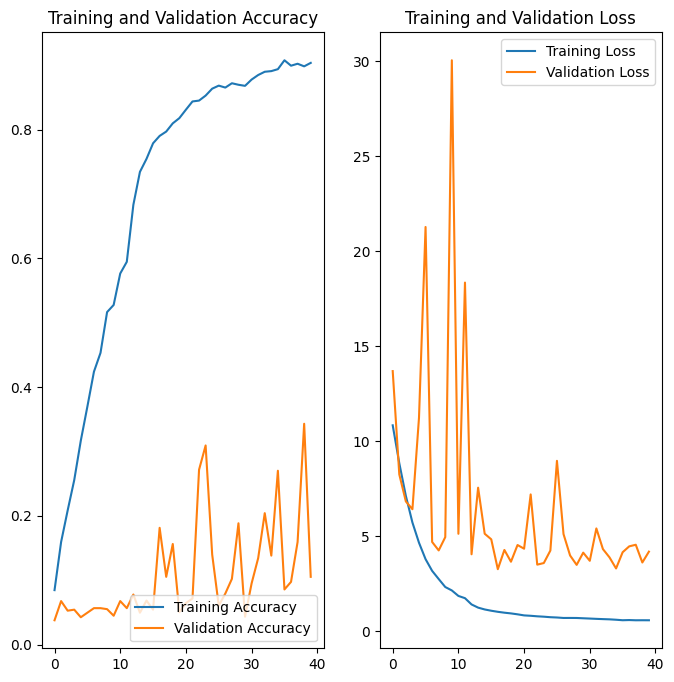

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_num.h5")

## Le programme de classification des race de chien est implémenté sur la platforme Streamlit.
Voici le lien vers l'application en ligne

https://leviks-formation-mlshahmirrian-levik-2-programme-062023-slhrdz.streamlit.app/

In [ ]:
import streamlit as st
from rembg import remove
from PIL import Image
from io import BytesIO
import base64
import numpy as np
import joblib
import keras
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils import img_to_array,load_img

st.set_page_config(layout="wide", page_title="Image Background Remover")

st.write("## Classez des images à l'aide d'algorithmes de Deep Learning")
st.write(
    ":dog:Téléchargez une image de chien pour découvrir sa race. Des images de qualité complète peuvent être téléchargées à partir de la barre latérale. Special thanks to the [rembg library](https://github.com/danielgatis/rembg) :grin:"
)
st.sidebar.write("## Charger et télécharger :gear:")
# Download the fixed image
def convert_image(img):
    buf = BytesIO()
    img.save(buf, format="PNG")
    byte_im = buf.getvalue()
    return byte_im


def fix_image(upload):
    image = Image.open(upload)
    col1.write("Image Originale:camera:")
    col1.write(" ")
    col1.write(" ")
    col1.write(" ")
    col1.image(image)

    fixed = remove(image)
    #col2.write("la race:wrench:")
    col2.image(fixed)
    st.sidebar.markdown("\n")
    st.sidebar.download_button("Télécharger l'image modiffiée", convert_image(fixed), "fixed.png", "image/png")

def write_predict(prob,imagenet_class_name):
    col2.write("la race:wrench:  "+imagenet_class_name)
    col2.write("la Probabilité   "+ str(prob))
    

#load model, set cache to prevent reloading

def load_model(img):
    json_file = open('/app/streamlit-example/Formation_ML/model_num.json', 'r')

    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights("/app/streamlit-example/Formation_ML/model_num.h5")
    #print("Loaded model from disk")

    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = loaded_model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    write_predict(prob,imagenet_class_name)
   

col1, col2 = st.columns(2)
my_upload = st.sidebar.file_uploader("Télécharger une image", type=["png", "jpg", "jpeg"])

if my_upload is not None:
    #fix_image(upload=my_upload)
    img = keras.utils.load_img(my_upload, target_size=(224, 224))
    img = keras.utils.img_to_array(img)
    
    load_model(img)

    fix_image(my_upload)
